# Setup

## Loading that data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

train = pd.read_csv('./ae-data/training_set.csv')
test = pd.read_csv('./ae-data/test_set.csv')

## Altered Dictionary

The "Harder to explain" variables are:

IMD_Decile_From_LSOA - IMD Decile Description. Goes from most deprived (1) to least deprived (10). Best to set to 5 if missing for now. The IMD Overall Ranking to identify which one of ten groups a Super Output Area belongs to, from most deprived through to least deprived.

Sex - Based on the data dictionary, 1 for Male and 2 for Female, 9 for Indeterminate. Make 0 (unknown) for missing.

AE_HRG - No idea. Not sure if it's important. Leaving it out.


# Preprocessing

## Handle missing values

In [2]:
## Removing columns with excessive number of null values
## THIS CELL IS VERY MUCH EDITABLE

# Define the threshold for missing values
missing_threshold = 0.5

# Identify columns in the training set that have more than 50% missing values
# Not dropping after some exploratory analysis. When it's present it is a good (perfect?) indicator of if someone has been admitted.

columns_to_drop_train = train.columns[((train.isnull().mean() > missing_threshold) & (train.columns != 'Length_Of_Stay_Days')) | (train.columns == 'AE_Arrive_HourOfDay')]

print(columns_to_drop_train)

# Drop these columns from the training set
train_drop = train.drop(columns_to_drop_train, axis=1)

# Drop the same columns from the test set
test_drop = test.drop(columns_to_drop_train, axis=1)

Index(['AE_Arrive_HourOfDay', 'ICD10_Chapter_Code', 'Treatment_Function_Code'], dtype='object')


In [3]:
# A few acceptable data transformations
# Set any null values in the 'Sex' column of test and train drop to 0

train_drop['Sex'] = train_drop['Sex'].fillna(0)

test_drop['Sex'] = test_drop['Sex'].fillna(0)

# Set any null values in the 'Provider_Patient_Distance_Miles' column of test and train drop to the mean of the column

train_drop['Provider_Patient_Distance_Miles'] = train_drop['Provider_Patient_Distance_Miles'].fillna(int(train_drop['Provider_Patient_Distance_Miles'].mean()))

test_drop['Provider_Patient_Distance_Miles'] = test_drop['Provider_Patient_Distance_Miles'].fillna(int(train_drop['Provider_Patient_Distance_Miles'].mean()))


# Set any null values in the 'IMD_Decile_From_LSOA' column of test and train drop to 5. This is the median value of the column.
train_drop['IMD_Decile_From_LSOA'] = train_drop['IMD_Decile_From_LSOA'].fillna(5)

test_drop['IMD_Decile_From_LSOA'] = test_drop['IMD_Decile_From_LSOA'].fillna(5)


# Set any null values of 'Length_Of_Stays_Days' to 0. Throught it would make more sense for them not to have been put in the database rather than have stayed and not been recorded.

train_drop['Length_Of_Stay_Days'] = train_drop['Provider_Patient_Distance_Miles'].fillna(0)

test_drop['Length_Of_Stay_Days'] = test_drop['Provider_Patient_Distance_Miles'].fillna(0)


# Replace 'NaN' in "EA_HRG" with the value "Nothing"

train_drop['AE_HRG'] = train_drop['AE_HRG'].fillna('Nothing')

test_drop['AE_HRG'] = test_drop['AE_HRG'].fillna('Nothing')


In [4]:
# ## Data removals
# ## Planning to remove all null values for Arrival Hour. This is because it feels like a pretty important feature and there are only a couple hundred missing, doubt it will sway things too much.

# train_drop = train_drop.dropna(subset=['AE_Arrive_HourOfDay'])

# test_drop = test_drop.dropna(subset=['AE_Arrive_HourOfDay'])

In [5]:
# Count of missing values in the training set
print(train_drop.isnull().sum())

# Count of missing values in the test set
print(test_drop.isnull().sum())

IMD_Decile_From_LSOA               0
Age_Band                           0
Sex                                0
AE_Arrive_Date                     0
AE_Time_Mins                       0
AE_HRG                             0
AE_Num_Diagnoses                   0
AE_Num_Investigations              0
AE_Num_Treatments                  0
AE_Arrival_Mode                    0
Provider_Patient_Distance_Miles    0
ProvID                             0
Admitted_Flag                      0
Length_Of_Stay_Days                0
Record_ID                          0
dtype: int64
IMD_Decile_From_LSOA               0
Age_Band                           0
Sex                                0
AE_Arrive_Date                     0
AE_Time_Mins                       0
AE_HRG                             0
AE_Num_Diagnoses                   0
AE_Num_Investigations              0
AE_Num_Treatments                  0
AE_Arrival_Mode                    0
Provider_Patient_Distance_Miles    0
ProvID                   

## Categorical Data Encoding

The Categroical variables in our dataset are:

- Age Band
- AE_Arrive_HourOfDay
- AE_HRG

We will perform one-hot encoding on the following variables:

- AE_Arrive_HourOfDay
- AE_HRG

And we will perfrom ordinal encoding on the following variables (this is we want to preserve the order of the categories, since they aren't really independent of each other):

- Age Band (There is a natural ordering to the age bands. If this fucks up classification downstream, we should try making this one-hot as well)

In [6]:
# train_encoded = pd.get_dummies(train_drop, columns=['AE_Arrive_HourOfDay','AE_HRG'])
train_encoded = pd.get_dummies(train_drop, columns=['AE_HRG'])


# test_encoded = pd.get_dummies(test_drop, columns=['AE_Arrive_HourOfDay','AE_HRG'])
test_encoded = pd.get_dummies(test_drop, columns=['AE_HRG'])


X = [["1-17",1], ["18-24",2], ["25-44",3], ["45-64",4], ["65-84",5], ["85",6]]
encoder = OrdinalEncoder(X)

encoder.fit(train[['Age_Band']])

train_encoded['Age_Band'] = encoder.transform(train_encoded[['Age_Band']])
test_encoded['Age_Band'] = encoder.transform(test_encoded[['Age_Band']])

## Date Processing

In [7]:
# First convert to datetime format
train_encoded['AE_Arrive_Date'] = pd.to_datetime(train_encoded['AE_Arrive_Date'])
test_encoded['AE_Arrive_Date'] = pd.to_datetime(test_encoded['AE_Arrive_Date'])

# Then extract date components
for df in [train_encoded, test_encoded]:
    df['Arrival_Year'] = df['AE_Arrive_Date'].dt.year
    df['Arrival_Month'] = df['AE_Arrive_Date'].dt.month
    df['Arrival_Day'] = df['AE_Arrive_Date'].dt.day
    df['Arrival_DayOfWeek'] = df['AE_Arrive_Date'].dt.dayofweek  # Monday=0, Sunday=6

# Drop the original 'AE_Arrive_Date' field
train_encoded = train_encoded.drop('AE_Arrive_Date', axis=1)
test_encoded = test_encoded.drop('AE_Arrive_Date', axis=1)

## Train/Val Splitting

This is in the wrong place. Should be done before any of the preprocessing steps, but am a little lazy to put it back. Will do later.
helps to prevent data leakage, where information from the validation set or test set influences the training process.

In [8]:
## Splitting the training data into training and validation sets

# Set the proportion of the dataset to include in the validation split
validation_size = 0.2

# Separate the features and the target variable in the training set
X_train = train_encoded.drop('Admitted_Flag', axis=1)
y_train = train_encoded['Admitted_Flag']

# Drop 'ProvID' from both sets
X_train = X_train.drop('ProvID', axis=1)
test_encoded = test_encoded.drop('ProvID', axis=1)

# Drop 'Record_ID' from the training set
X_train = X_train.drop('Record_ID', axis=1)

# Keep a copy of 'Record_ID' from the test set and then drop it from the test set
test_record_id = test_encoded['Record_ID']
test_encoded = test_encoded.drop('Record_ID', axis=1)

# Split the training data into a smaller training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=validation_size, random_state=42)


## Feature Scaling

In [9]:
# Choose standardization or min-max scaling
# This is not needed for decision trees and random forests as they are not affected by the scale of the data
# Needed for logistic regression, SVM, perceptron, kNN, neural networks, etc.

# scaler = StandardScaler() - resulting distribution has a mean of 0 and a standard deviation of 1
scaler = MinMaxScaler()  # - transforms your data to a range between 0 and 1

# Fit on training data
scaler.fit(X_train)

# Transform both training and test data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(scaler.transform(X_val), columns=X_val.columns)
test = pd.DataFrame(scaler.transform(test_encoded), columns=test_encoded.columns)

## RUN, THAT (STANDARD) MODEL

In [10]:
# Random Forests pipeline
pipeline_rf = Pipeline([
    ('rf', RandomForestClassifier(random_state=42))
])

# SVM pipeline
pipeline_svm = Pipeline([
    ('svm', SVC(random_state=42))
])

# Logistic Regression pipeline
pipeline_lr = Pipeline([
    ('lr', LogisticRegression(random_state=42))
])

pipelines = [pipeline_rf, pipeline_svm, pipeline_lr]
pipeline_names = ['Random Forests', 'SVM', 'Logistic Regression']

for i, pipeline in enumerate(pipelines):
    # Fit the pipeline on the training data
    pipeline.fit(X_train, y_train)
    
    # Make predictions on the validation data
    y_val_pred = pipeline.predict(X_val)
    
    # Evaluate the predictions
    accuracy = accuracy_score(y_val, y_val_pred)
    
    print(f'{pipeline_names[i]} validation accuracy: {accuracy}')


Random Forests validation accuracy: 0.8217
SVM validation accuracy: 0.8139
Logistic Regression validation accuracy: 0.81115


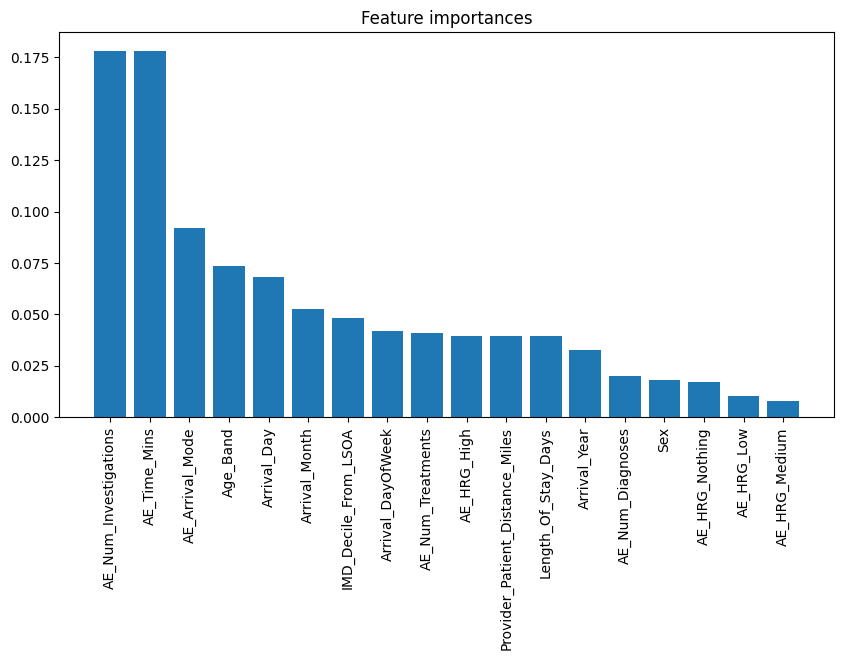

In [11]:
## Perform a prediction with the best performing model on the test set, and output the results to a CSV file

# Make predictions on the test set

y_test_pred = pipeline_rf.predict(test)

# Create a dataframe with the patient ID and the predicted probability of being admitted
results = pd.DataFrame({'Record_ID': test_record_id, 'Admitted_Flag': y_test_pred})

# Save the dataframe to a CSV file

results.to_csv('results.csv', index=False)

# Plot the feature importances

importances = pipeline_rf.named_steps['rf'].feature_importances_

# Sort importances
sorted_index = np.argsort(importances)[::-1]
x = range(len(importances))

# Create tick labels
labels = np.array(X_train.columns)[sorted_index]

plt.figure(figsize=(10,5))
plt.bar(x, importances[sorted_index])
plt.xticks(x, labels, rotation=90)
plt.title('Feature importances')
plt.show()